# Variogram Model  


Here we fit a variogram model to the experimental variogram calculated in the Experimental_Variogram example. Why fit a parametric variogram model to the experimental variogram? First of all, we need a way to interpolate variance estimates to all lag distances. Second, a variogram must satisfy certain mathematical properties in order to be used in kriging and stochastic simulation. This is covered in the Simple_Kriging.ipynb notebook.

The parameters of a variogram model are the nugget, sill, and range. The nugget or y-intercept represents small scale variability. Some of the nugget effect could be attributed to measurement error. The range is the lag distance where the variogram levels off. This means that two points separated by a lag distance greater than or equal to the range are not spatially correlated. The sill is the maximum variability between two points. When working with data that has been transformed to a standard Gaussian distribution, the sill is approximately 1. 


:::{figure-md} markdown-fig
<img src="./Images/variogram.png" class="bg-primary mb-1" width="500px">

Variogram schematic
:::

We use the SciKit-GStat package to model our variograms (see https://scikit-gstat.readthedocs.io/en/latest/ for more details).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import QuantileTransformer 
import skgstat as skg
from skgstat import models
import gstatsim as gs

## Load and plot data

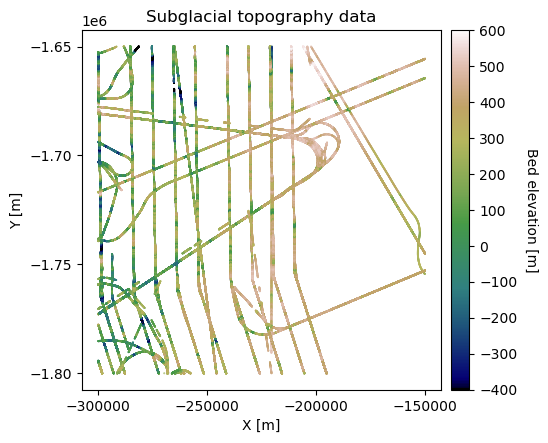

In [2]:
df_bed = pd.read_csv('data/greenland_test_data.csv')

# remove erroneously high values due to bad bed picks
df_bed = df_bed[df_bed["Bed"] <= 700]  

# plot data
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.scatter(df_bed['X'], df_bed['Y'], c=df_bed['Bed'], vmin=-400, vmax=600, 
                     marker='.', s=0.5, cmap='gist_earth')
plt.title('Subglacial topography data')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.locator_params(nbins=5)
plt.axis('scaled')

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
plt.show()

## Normal score transformation and experimental variogram

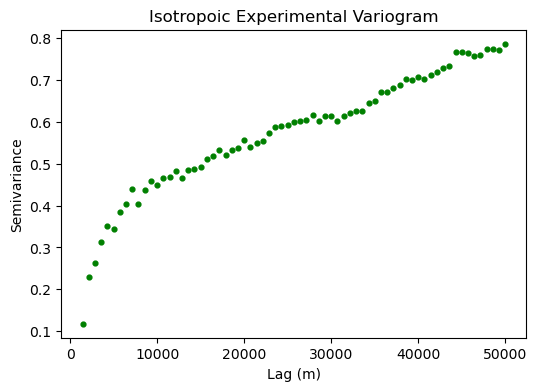

In [3]:
# grid data to 1000 m resolution and remove coordinates with NaNs
res = 1000
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Bed"})

# normal score transformation
data = df_grid['Bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000          # maximum range distance
n_lags = 70             # num of bins

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, 
                   maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropoic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')  
plt.show()

## Fit variogram model

The variogram parameters are determined automatically using the SciKit-GStat functions:

In [4]:
# use exponential variogram model
V1.model = 'exponential' 
V1.parameters

[31852.813386947026, 0.7027482243110261, 0]

The outputs are the range, sill, and nugget, respectively. The SciKit-GStat has a default nugget of 0 unless specified (see SciKit-GStat documentation).

In [5]:
# use Gaussian model
V2 = V1
V2.model = 'gaussian' 
V2.parameters

[13941.920295334547, 0.629787720709971, 0]

In [6]:
# use spherical model
V3 = V1
V3.model = 'spherical' 
V3.parameters

[20826.484526850974, 0.6530605719749214, 0]

These values are the range, sill, and nugget, respectively. The range describes the correlation length, or distance where two measurements are no longer correlated The sill is variance where the range is reached. The nugget is the variance at a lag distance of zero. 

The nugget effect is often attributed to measurement error (i.e., a non-zero nugget results from measurements with different values at the same location). We have a nugget of zero because our data is gridded. Depending on the analysis, it can be useful to work with non-gridded data in order to investigate the nugget effect and measurement uncertainty. For certain interpolation problems, it is best to have a nugget of zero, while sometimes it is useful to include the nugget.

Now we will create the variogram model. There are many different types of variogram models (see SCiKit-GStat documentation). GStatSim has options for exponential, Gaussian, and spherical variogram models. The exponential variogram is:

$$
\gamma_{exp}(h) = b + (c - b)[1 - exp^{(-\frac{3h}{a})}]
$$

where $b$ is the nugget, $h$ is the lag distance, $c$ is the sill, and $a$ is the range. Note that the SCiKit-GStat variogram modeling defaults assign a nugget of 0. The Gaussian variogram is:

$$
\gamma_{Gauss}(h) = b + (c - b)[1 - exp^{(-\frac{3h^2}{a^2})}].
$$

And the spherical variogram is:

$$
\gamma_{sph}(h) = \begin{cases} b + (c - b)[1.5*\frac{h}{a} - 0.5*\frac{h^3}{a^3}] & \text{if $0<h \leq a$}\\
    c & \text{if $h > a$}
\end{cases}.
$$

These different variogram model types all have different properties, and some are better at modeling certain data sets than others. In practice, it's good to try fitting different variogram models to the data and determine which one fits best.

In [7]:
# evaluate models
xi =np.linspace(0, xdata[-1], 100) 

y_exp = [models.exponential(h, V1.parameters[0], V1.parameters[1], V1.parameters[2]) for h in xi]
y_gauss = [models.gaussian(h, V2.parameters[0], V2.parameters[1], V2.parameters[2]) for h in xi]
y_sph = [models.spherical(h, V3.parameters[0], V3.parameters[1], V3.parameters[2]) for h in xi]

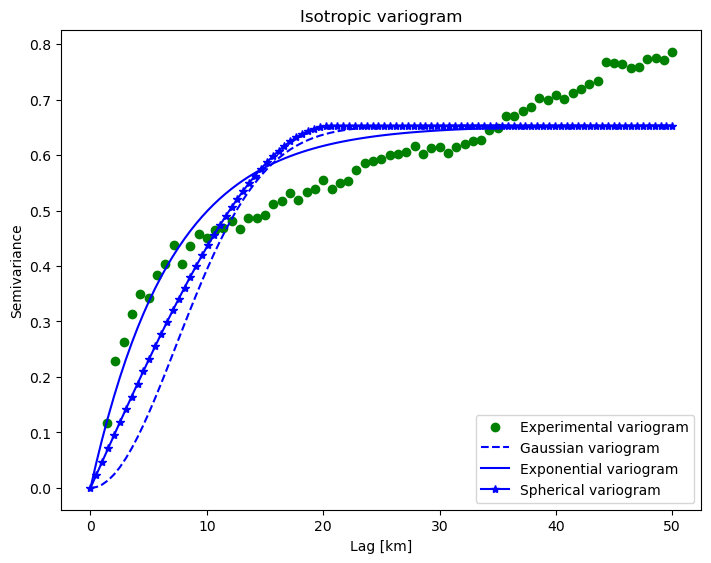

In [8]:
# plot variogram model
fig = plt.figure()
plt.plot(xdata/1000,ydata,'og', label = "Experimental variogram")
plt.plot(xi/1000, y_gauss,'b--', label='Gaussian variogram')
plt.plot(xi/1000, y_exp,'b-', label='Exponential variogram')
plt.plot(xi/1000, y_sph,'b*-', label='Spherical variogram')
plt.title('Isotropic variogram')
plt.xlabel('Lag [km]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0) # adjust the plot size
plt.legend(loc='lower right')

By looking at the variogram models, we can see that the exponential model fits the best. As such, we will use the exponential variogram model type to perform interpolations.

For anisotropic variograms, the variogram should be modeled in the major (smoothest) and minor (roughest) directions, which are typicaly orthogonal to each other.

Now that the variogram is modeled, we can use this information to perform interpolations.

Download the tutorial {Download}`here<./2_Variogram_model.ipynb>`.